# Test function on images

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
%matplotlib inline

In [3]:
# Unpickle camera calibration data
with open("./camera_cal/calibration_data.p",'rb') as cal_f:
    calibration_data = pickle.load(cal_f) 
mtx = calibration_data['mtx']
dist = calibration_data['dist']

In [4]:
# Load all images
images = glob.glob("./test_images/*.jpg")
images

['./test_images/straight_lines1.jpg',
 './test_images/test2.jpg',
 './test_images/straight_lines2.jpg',
 './test_images/test4.jpg',
 './test_images/test1.jpg',
 './test_images/test6.jpg',
 './test_images/test5.jpg',
 './test_images/test3.jpg']

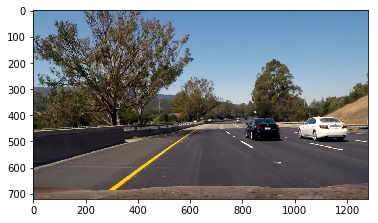

In [5]:
sample_img = mpimg.imread(images[5])
plt.imshow(sample_img)

### 1. Undistort image

In [6]:
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

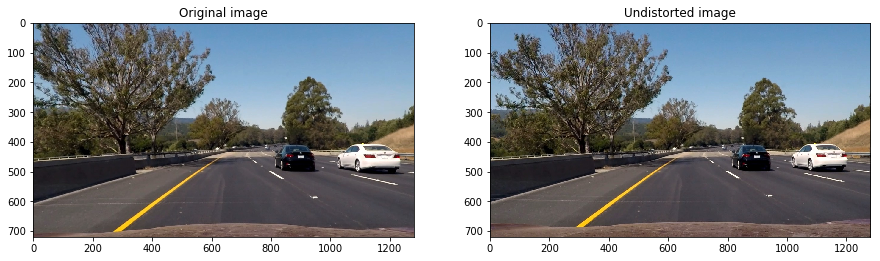

In [7]:
undist_img = undistort(sample_img, mtx, dist)
f, axs = plt.subplots(1,2, figsize=(15,30))
axs[0].imshow(undist_img)
axs[0].set_title("Original image")
axs[1].imshow(sample_img)
axs[1].set_title("Undistorted image")
plt.show()

path = "./output_images/"
f.savefig(path+"undist_road.jpg")

### 2. Color and Gradient Trasformations

In [8]:
def sobel_filter(img, mode='x', low_thresh=0, high_thresh=255, kernel=3):
    
    # Select mode between gradient in x or y, magnitude and direction
    if mode in ['x','y','mag']:
        
        x_flag = int(mode == 'x')
        y_flag = int(mode == 'y')  
        if x_flag or y_flag:
            sobel_out = cv2.Sobel(img, cv2.CV_64F, x_flag, y_flag, ksize=kernel)
            abs_sobel = np.abs(sobel_out)
        else:
            sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
            sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
            abs_sobel = np.sqrt(sobel_x**2 + sobel_y**2)
        
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        
        # Threshold absolute gradient
        sobel_binary = np.zeros_like(scaled_sobel)
        sobel_binary[(scaled_sobel >= low_thresh) & (scaled_sobel <= high_thresh)] = 1
        
    else:
        print("Sobel param 'mode' must correnspond to one of the following values: 'x','y','mag','dir'")
        sys.exit(-1)
    
    return sobel_binary

In [9]:
def color_filter(img, low_thresh, high_thresh):
    color_binary = np.zeros_like(img)
    color_binary[(img >= low_thresh) & (img <= high_thresh)] = 1
    return color_binary

In [10]:
def color_gradient_transform(img, transforms, comb_function):
    """
    Perform color and gradient transformations and return binary image according to the given thresholds.
    
    The image can undergo both/either one color transformation and/or one Sobel transformation.
    
    It takes as input an RGB image and a list a dictionaries containing the transformation parameters.
    
    Please convert BGR to RGB!
    
    Color Params:
    - type: set to 'color'
    - channel: rgb or hls, gray: 'r','g','b', 'h', 'l','s', 'gray'
    - low_threshold: int in range [0, 255], smaller than high_threshold
    - high_threshold: int in range [0, 255], greate than small_threshold
    
    Sobel Params:
    - s
    - mode: x, y, m, dir
    - channel: rgb or hls 'r','g','b', 'h', 'l','s'
    - low_threshold: int in range [0, 255], smaller than high_threshold
    - high_threshold: int in range [0, 255], greate than small_threshold
    - kernel: kernel size of sobel filter, must be an odd number 
    """
    
    # Compute color transformations only if required by a filter
    img_channel = {}
    channels = set([])
    for params in transforms:
        if params:
            channels = channels.union({params['channel']})
            
    if channels & {'h','l','s'}:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img_channel['h'] = hls[:,:,0]
        img_channel['l'] = hls[:,:,1]
        img_channel['s'] = hls[:,:,2]
        
    if channels & {'r','g','b'}:
        img_channel['r'] = img[:,:,0]
        img_channel['g'] = img[:,:,1]
        img_channel['b'] = img[:,:,2]
        
    if 'gray' in channels:
        img_channel['gray'] = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    imgs = [np.zeros_like(img[:,:,0])]
        
    # Compute required filters
    for params in transforms:
        if params['type'] == 'sobel':
            imgs.append(sobel_filter(img_channel[params['channel']], params['mode'],
                                       params['low_thresh'], params['high_thresh'],
                                       params['kernel']))
        elif params['type'] == 'color':
            imgs.append(color_filter(img_channel[params['channel']],
                                       params['low_thresh'], params['high_thresh']))
            
    
    cgt_img = comb_function(imgs)
    
    return cgt_img

In [11]:
def comb_function(imgs):
    combi = imgs[0]
    combi[((imgs[1] == 1) & (imgs[2] == 1)) | (imgs[3] == 1)] = 1
    return combi

In [12]:
sobelxparams = {
    'type': 'sobel',
    'channel': 'gray',
    'mode': 'x',
    'low_thresh': 20,
    'high_thresh': 100,
    'kernel': 5
}

sobelyparams = {
    'type': 'sobel',
    'channel': 'gray',
    'mode': 'y',
    'low_thresh': 20,
    'high_thresh': 100,
    'kernel': 5
}

colorparams = {
    'type': 'color',
    'channel': 's',
    'low_thresh': 150,
    'high_thresh': 255
}

filter_params = [sobelxparams, sobelyparams, colorparams]
combi = color_gradient_transform(undist_img, filter_params, comb_function)

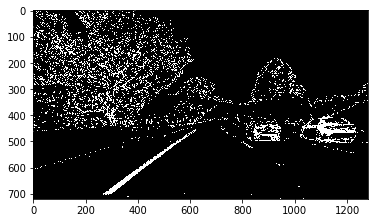

In [13]:
plt.imshow(combi, cmap='gray')
plt.show()
mpimg.imsave(path+"cg_filters.jpg", combi, cmap='gray')

### 3. Perspective transform 

In [14]:
def perspective_transform(img, M, transf=cv2.INTER_LINEAR):
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=transf)
    return warped

Transformation matrix is supposed to be calculated only once since the masking region is always the same

In [15]:
imshape = combi.shape # [y, x]
trap_topwidth = 0.1
trap_bottomwidth = .7
trap_height = 0.37
warp_width = .57
bottom_offset = 0.08
# src and s
src = np.float32([[imshape[1] * (1 - trap_bottomwidth)/2,imshape[0]*(1 - bottom_offset)],
                  [imshape[1] * (1 - trap_topwidth)/2, imshape[0] * (1 - trap_height)],
                  [imshape[1] * (1 + trap_topwidth)/2, imshape[0] * (1 - trap_height)],
                  [imshape[1] * (1 + trap_bottomwidth)/2, imshape[0]*(1 - bottom_offset)]])
dst = np.float32([[imshape[1] * (1 - warp_width)/2, imshape[0]*(1 - bottom_offset)],
                  [imshape[1] * (1 - warp_width)/2, 0],
                  [imshape[1] * (1 + warp_width)/2, 0],
                  [imshape[1] * (1 + warp_width)/2, imshape[0]*(1 - bottom_offset)]])

In [16]:
imshape = combi.shape # [y, x]
trap_topwidth = 0.085
trap_bottomwidth = .60
trap_height = 0.37
warp_width = .5
bottom_offset = 0.08
# src and s
src = np.float32([[imshape[1] * (1 - trap_bottomwidth)/2,imshape[0]*(1 - bottom_offset)],
                  [imshape[1] * (1 - trap_topwidth)/2, imshape[0] * (1 - trap_height)],
                  [imshape[1] * (1 + trap_topwidth)/2, imshape[0] * (1 - trap_height)],
                  [imshape[1] * (1 + trap_bottomwidth)/2, imshape[0]*(1 - bottom_offset)]])
dst = np.float32([[imshape[1] * (1 - warp_width)/2, imshape[0]*(1 - bottom_offset)],
                  [imshape[1] * (1 - warp_width)/2, 0],
                  [imshape[1] * (1 + warp_width)/2, 0],
                  [imshape[1] * (1 + warp_width)/2, imshape[0]*(1 - bottom_offset)]])

In [17]:
std_lane_width = 3.6
pixels_lane = imshape[1] * warp_width
xpm = std_lane_width / pixels_lane

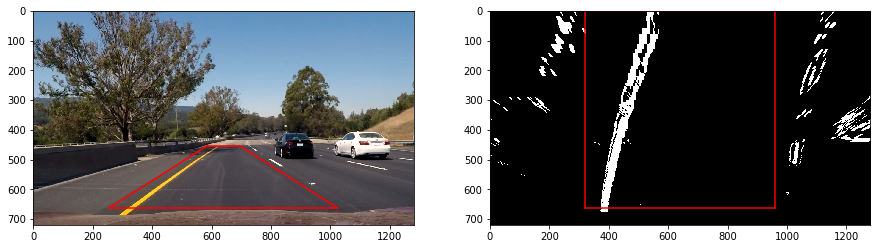

In [18]:
M = cv2.getPerspectiveTransform(src, dst)
warped_img = perspective_transform(combi, M)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,30))

ax1.imshow(sample_img)
ax1.plot(src[0:2,0], src[0:2,1],c='r')
ax1.plot(src[1:3,0], src[1:3,1],c='r')
ax1.plot(src[2:4,0], src[2:4,1],c='r')
ax1.plot(src[[0,3],0], src[[0,3],1],c='r')

ax2.imshow(warped_img, cmap='gray')
ax2.plot(dst[0:2,0], dst[0:2,1],c='r')
ax2.plot(dst[1:3,0], dst[1:3,1],c='r')
ax2.plot(dst[2:4,0], dst[2:4,1],c='r')
ax2.plot(dst[[0,3],0], dst[[0,3],1],c='r')

plt.show()
f.savefig(path+"perspective_transform.jpg")

### 4. Histogram ans sliding window

In [19]:
def find_lane_pixels(binary_warped, nwindows = 9, margin = 100, minpix = 50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [20]:
def fit_polynomial(binary_warped, viz_flag=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    if viz_flag:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img, cmap='gray')

    return left_fit, right_fit

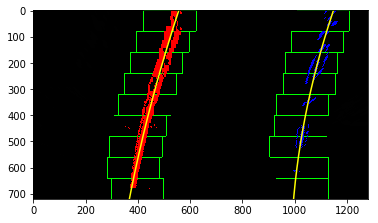

In [21]:
left_fit, right_fit = fit_polynomial(warped_img, True)
plt.savefig(path + "sliding_window.jpg")

###  5. Search from prior

In [22]:
def search_around_poly(binary_warped, left_fit, right_fit, margin=100, viz_flag=False):

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    ## Visualization ##
    if viz_flag:
        
        # Calc both polynomials using ploty, left_fit and right_fit
        left_fitx = np.polyval(left_fit, ploty)
        right_fitx = np.polyval(right_fit, ploty)
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(result)
    ## End visualization steps ##
    
    return left_fit, right_fit

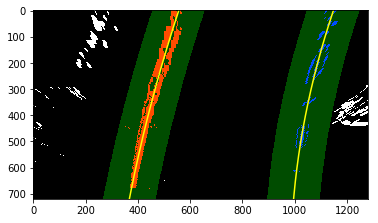

In [23]:
lfits, rfits = search_around_poly(warped_img, left_fit, right_fit, viz_flag=True)
plt.savefig(path + "search_prior.jpg")

### 7. Measure curvature and offset

In [43]:
def measure_curvature_real(left_fit_cr, right_fit_cr, bottom_offset, imshape,ym_per_pix = 30/720, xm_per_pix = 3.7/700):
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = imshape[0] * (1-bottom_offset)  * ym_per_pix
    
    # Implement the calculation of R_curve (radius of curvature)
    left_curverad = (1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**(3/2) / np.abs(2*left_fit_cr[0])
    right_curverad =(1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**(3/2) / np.abs(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [44]:
def measure_offset(left_fit,right_fit, dst, imshape, xm_per_pix = 3.7/700):
    y_eval = dst[3,1]
    left_point = np.polyval(left_fit, y_eval)
    right_point = np.polyval(right_fit, y_eval)
    lane_center_pos = (right_point + left_point)//2
    offset_pix = lane_center_pos - imshape[1]//2
    offset  = offset_pix * xm_per_pix
    return offset

In [47]:
# Compute curvature
leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_img)
xm_per_pix = 3.7/700
ym_per_pix = 30/720
leftx_real = leftx * xm_per_pix
rightx_real = rightx * xm_per_pix
lefty_real = lefty * ym_per_pix
righty_real = righty * ym_per_pix
left_coeff_real = np.polyfit(lefty_real, leftx_real, 2)
right_coeff_real = np.polyfit(righty_real, rightx_real, 2)
left_curvature, right_curvature = measure_curvature_real(left_coeff_real, right_coeff_real, bottom_offset, 
                                                        imshape, ym_per_pix, xm_per_pix)
(left_curvature, right_curvature)

(1755.3217523632859, 951.83467230125609)

In [48]:
# Compute offset
measure_offset(left_fit, right_fit, dst, imshape)

0.26428571428571429

### 8. Draw lines on image

In [28]:
def draw_lines(frame, binary_warped, Minv, left_fit, right_fit):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Prepare data
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (frame.shape[1], frame.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(frame, 1, newwarp, 0.3, 0)
    
    return result

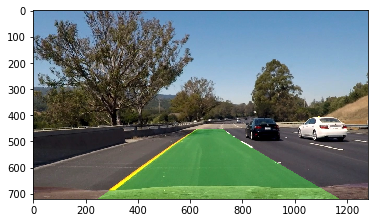

In [29]:
Minv = cv2.getPerspectiveTransform(dst, src)
final_img = draw_lines(sample_img, warped_img, Minv, left_fit, right_fit)
plt.imshow(final_img)
mpimg.imsave(path+"lines_drawn.jpg", final_img)

# Refactoring code to process video stream

In [27]:
class Processor():
    """ 
    The purpose of this class is to store all the hyperparameters and previous lane data as attributes, so that 
    the process_frame method can be passed to the movie processor and access all such attributes.
    
    It has to be initalized with all the hyperparameters necessary at the various steps.
    
    Call the reset_lines method before processing a new video when reusing the same Processor object on 
    more videos
    """
    
    def __init__(self, mtx, dist, filter_params, comb_function, imshape=(720,1280,3),
                 trap_topwidth=0.085,trap_bottomwidth=.6,trap_height=.37,warp_width=.5,bottom_offset=.08,
                 nframes=10, nwindows=9, minpix=50, width=80, window_margin=25, prior_margin=100,
                 xmp=3.6/640, ymp=1):
        
        # Hyperparameters for undistortion and filter
        self.mtx = mtx
        self.dist = dist
        self.filter_params = filter_params
        self.comb_function = comb_function
        
        # Parameters for perspective transform
        self.trap_topwidth = trap_topwidth
        self.trap_bottomwidth = trap_bottomwidth
        self.trap_height = trap_height
        self.warp_width = warp_width
        self.bottom_offset = bottom_offset
        self.imshape = imshape
        self.src = np.float32([[self.imshape[1] * (1 - self.trap_bottomwidth)/2,self.imshape[0]*(1 - self.bottom_offset)],
                      [self.imshape[1] * (1 - self.trap_topwidth)/2, self.imshape[0] * (1 - self.trap_height)],
                      [self.imshape[1] * (1 + self.trap_topwidth)/2, self.imshape[0] * (1 - self.trap_height)],
                      [self.imshape[1] * (1 + self.trap_bottomwidth)/2, self.imshape[0]*(1 - self.bottom_offset)]])
        self.dst = np.float32([[self.imshape[1] * (1 - self.warp_width)/2, self.imshape[0]*(1 - bottom_offset)],
                      [self.imshape[1] * (1 - self.warp_width)/2, 0],
                      [self.imshape[1] * (1 + self.warp_width)/2, 0],
                      [self.imshape[1] * (1 + self.warp_width)/2, self.imshape[0]*(1 - self.bottom_offset)]])
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.Minv = cv2.getPerspectiveTransform(self.dst, self.src)
        
        # Hyperparameters
        self.nframes = nframes
        self.nwindows = nwindows
        self.minpix = minpix
        self.width = width
        self.window_margin = window_margin
        self.prior_margin = prior_margin
        self.xmp = xmp
        self.ymp = ymp

        # Initialized attributes
        self.right_line = Line()
        self.left_line = Line()
        self.first_frame = True
        self.lane_width = np.array([])
        self.offset = np.array([])
        
    def reset_lines(self):
        self.right_line = Line()
        self.left_line = Line()
        self.first_frame = True
    
    def process_frame(self, frame):
        """
        Function to be passed to the video stream
        """
        
        # First steps, unconditionally necessary
        undist_frame = undistort(frame, self.mtx, self.dist)
        binary_frame = color_gradient_transform(undist_frame, self.filter_params, self.comb_function)
        binary_warped = perspective_transform(binary_frame, self.M)
    
        
        # Update lines: search from prior, sliding window, use previous
        if self.first_frame:
            left_coeffs, right_coeffs = self.sliding_window(binary_warped)
            try:
                self.left_line.measure_curvature(left_coeffs, self.dst[3,1]*self.ymp)
                self.right_line.measure_curvature(right_coeffs, self.dst[3,1]*self.ymp)
                self.left_line.update(left_coeffs)
                self.right_line.update(right_coeffs)
                
                self.first_frame = False
            except:
                self.left_line.update_without()
                self.right_line.update_without()
                self.lane_width = np.ones(self.tframe) * np.nan
                self.offset = np.ones(self.tframe) * np.nan
                
        else:
            
            # Try to search around previous polynomial
            try:
                left_coeffs, right_coeffs = self.search_around_poly(binary_warped, self.left_line.curr_coeffs, 
                                                               self.right_line.curr_coeffs)
                self.left_line.measure_curvature(left_coeffs, self.dst[3,1]*self.ymp)
                self.right_line.measure_curvature(right_coeffs, self.dst[3,1]*self.ymp)
                lflag_prior = self.left_line.catch_outlier(left_coeffs)
                rflag_prior = self.right_line.catch_outlier(right_coeffs)
                flag_prior = lflag_prior or rflag_prior
            except:
                flag_prior = True
            
            # Use sliding window is one of the two lines couldn't be detected at previous step
            if flag_prior:
                left_coeffs, right_coeffs = self.sliding_window(binary_warped)
                lflag_slide = self.left_line.catch_outlier(left_coeffs)
                rflag_slide = self.right_line.catch_outlier(right_coeffs)
            else:
                lflag_slide = False
                rflag_slide = False
                
            # Update left line
            if flag_prior and lflag_slide:
                self.left_line.update_without()
            else:
                self.left_line.measure_curvature(left_coeffs, self.dst[3,1]*self.ymp)
                self.left_line.update(left_coeffs)
            
            # Update right line
            if flag_prior and rflag_slide:
                self.right_line.measure_curvature(right_coeffs, self.dst[3,1]*self.ymp)
                self.right_line.update_without()
            else:
                self.right_line.update(right_coeffs)
                
        # Update various values
        self.update_values()
        
        # Draw lines or nothing if first frame has not been detected
        try:
            annotated_frame = self.draw_lines(undist_frame, binary_warped, self.left_line.curr_coeffs,
                                         self.right_line.curr_coeffs)
        except:
            annotated_frame = np.copy(frame)
            
        return annotated_frame
    
    def measure_offset(self, lc, rc):
        # Road line closest to the car
        y_eval = self.dst[3,1]
        left_point = np.polyval(lc, y_eval)
        right_point = np.polyval(rc,y_eval)
        
        # Lane width
        lane_width_pix = right_point - left_point
        lane_width = lane_width_pix * self.xmp
        
        # Car lateral respect w.r.t. lane center
        lane_center_pos = (right_point + left_point)//2
        offset_pix = lane_center_pos - self.imshape[1]//2
        offset  = offset_pix * self.xmp
        
        return lane_width, offset
    
    def update_values(self):
        lane_width, offset = self.measure_offset(self.left_line.curr_coeffs,
                                                 self.right_line.curr_coeffs)
        self.lane_width = np.append(self.lane_width, lane_width)
        self.offset = np.append(self.offset, offset)
        
        return
 
    def sliding_window(self, binary_warped):

        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows - based on self.nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//self.nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in self.nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.window_margin
            win_xleft_high = leftx_current + self.window_margin
            win_xright_low = rightx_current - self.window_margin
            win_xright_high = rightx_current + self.window_margin

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > self.minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        leftx_real = leftx * self.xmp
        lefty_real = lefty * self.ymp
        rightx_real = rightx * self.xmp
        righty_real = righty * self.ymp
    

        # Fit a second order polynomial to each using `np.polyfit`
        try:
            left_fit = np.polyfit(lefty, leftx, 2)
            left_fit_real = np.polyfit(lefty_real, leftx_real, 2)
        except:
            left_fit = False
        try:
            right_fit = np.polyfit(righty, rightx, 2)
            right_fit_real = np.polyfit(righty_real, rightx_real, 2)
        except:
            left_fit = False

        return left_fit, right_fit
    

    def draw_lines(self, frame, binary_warped, left_fit, right_fit):

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Prepare data
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = np.polyval(left_fit, ploty)
        right_fitx = np.polyval(right_fit, ploty)

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (self.Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (frame.shape[1], frame.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(frame, 1, newwarp, 0.3, 0)

        return result

    def search_around_poly(self, binary_warped, left_fit, right_fit):

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - self.prior_margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + self.prior_margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - self.prior_margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + self.prior_margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        return left_fit, right_fit

In [28]:
class Line():
    
    def __init__(self, nframes=10):
        # Current polynomial coefficients
        self.detected = np.array([])
        self.coeffs = None
        self.unfiltered_coeffs = None
        self.curr_coeffs = None
        self.nframes = nframes
        self.tframe = 0
        self.temp_curvature = None
        self.curvature = np.array([])
    
    def update(self, coeffs):
        
        self.tframe = self.tframe + 1
        self.detected = np.append(self.detected, True)
        span_avg = self.nframes if self.nframes < self.tframe else self.tframe
        
        try:
            self.unfiltered_coeffs = np.vstack([self.unfiltered_coeffs, coeffs])
            self.curr_coeffs = np.mean(self.unfiltered_coeffs[-span_avg:,:], axis=0)
            self.coeffs = np.vstack([self.coeffs, self.curr_coeffs])
        except:
            self.curr_coeffs = coeffs
            self.unfiltered_coeffs = coeffs
            self.coeffs = coeffs
            
        self.curvature = np.append(self.curvature, self.temp_curvature)
        
        return

    def update_without(self):
        
        self.tframe = self.tframe + 1
        self.detected = np.append(self.detected, False)
        span_avg = self.nframes if self.nframes < self.tframe else self.tframe
        
        self.unfiltered_coeffs = np.vstack([self.unfiltered_coeffs, self.unfiltered_coeffs[-1,:]])
        self.curr_coeffs = np.mean(self.unfiltered_coeffs[-span_avg:,:], axis=0)
        self.coeffs = np.vstack([self.coeffs, self.curr_coeffs])
        
        self.curvature = np.append(self.curvature, self.curvature[-1])
        
        return
    
    def catch_outlier(self,coeffs,avar=10e-5,bvar=0.10,cvar=100,curvar=1e10):
        try:
            var_array = np.abs(coeffs - self.curr_coeffs) > np.array([avar,bvar,cvar])
            flag = (np.sum(var_array) == 3)
        except:
            flag = True
        return flag
    
    def measure_curvature(self, coeffs_real, y_eval):
        self.temp_curvature = (1 + (2*coeffs_real[0]*y_eval + coeffs_real[1])**2)**(3/2) / np.abs(2*coeffs_real[0])
        return

In [50]:
proc = Processor(mtx, dist, filter_params, comb_function)
video_output = 'video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(proc.process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video video_output.mp4
[MoviePy] Writing video video_output.mp4


100%|█████████▉| 1260/1261 [05:01<00:00,  4.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output.mp4 

CPU times: user 2min 8s, sys: 44.8 s, total: 2min 53s
Wall time: 5min 4s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

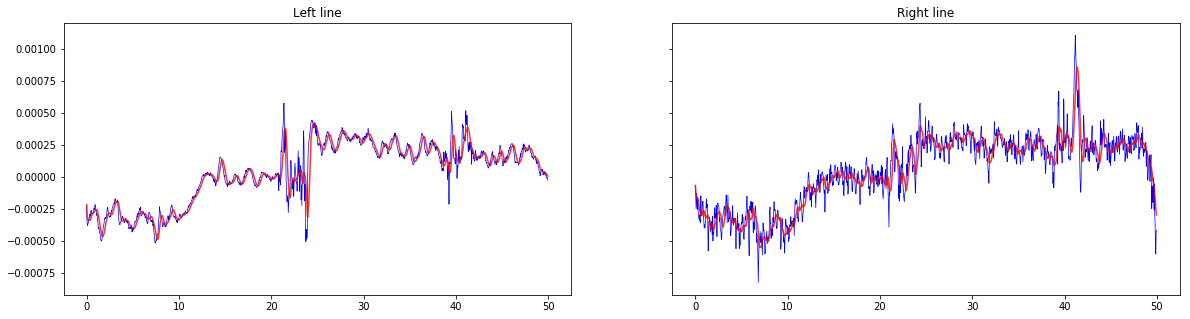

In [52]:
# 
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=True)
x = np.arange(proc.right_line.tframe) / (1261/50)
ax[0].plot(x,proc.left_line.unfiltered_coeffs[:,0],c='b', linewidth=0.7)
ax[0].plot(x,proc.left_line.coeffs[:,0],c='r',alpha=0.8)
ax[0].set_title("Left line")
ax[1].plot(x,proc.right_line.unfiltered_coeffs[:,0],c='b', linewidth=0.7)
ax[1].plot(x,proc.right_line.coeffs[:,0],c='r',alpha=0.8)
ax[1].set_title("Right line")
plt.show()

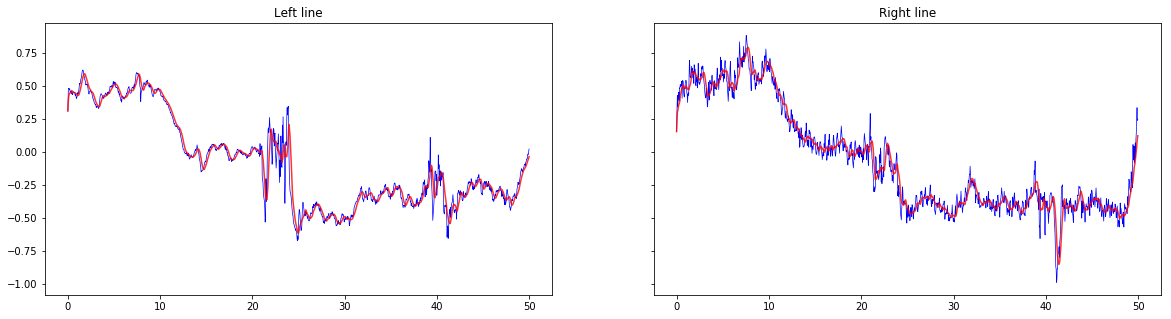

In [53]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=True)
ax[0].plot(x,proc.left_line.unfiltered_coeffs[:,1],c='b', linewidth=0.7)
ax[0].plot(x,proc.left_line.coeffs[:,1],c='r',alpha=0.8)
ax[0].set_title("Left line")
ax[1].plot(x,proc.right_line.unfiltered_coeffs[:,1],c='b', linewidth=0.7)
ax[1].plot(x,proc.right_line.coeffs[:,1],c='r',alpha=0.8)
ax[1].set_title("Right line")
plt.show()

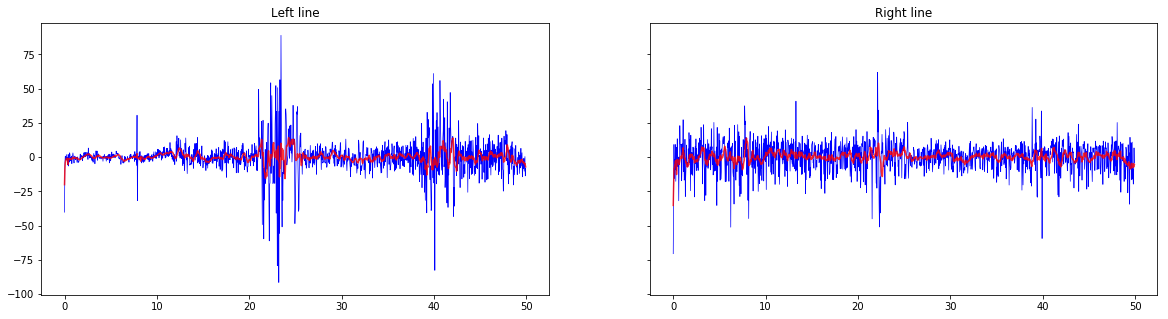

In [54]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=True)
ax[0].plot(x[:-1],np.diff(proc.left_line.unfiltered_coeffs[:,2]),c='b', linewidth=0.7)
ax[0].plot(x[:-1],np.diff(proc.left_line.coeffs[:,2]),c='r',alpha=0.8)
ax[0].set_title("Left line")
ax[1].plot(x[:-1],np.diff(proc.right_line.unfiltered_coeffs[:,2]),c='b', linewidth=0.7)
ax[1].plot(x[:-1],np.diff(proc.right_line.coeffs[:,2]),c='r',alpha=0.8)
ax[1].set_title("Right line")
plt.show()

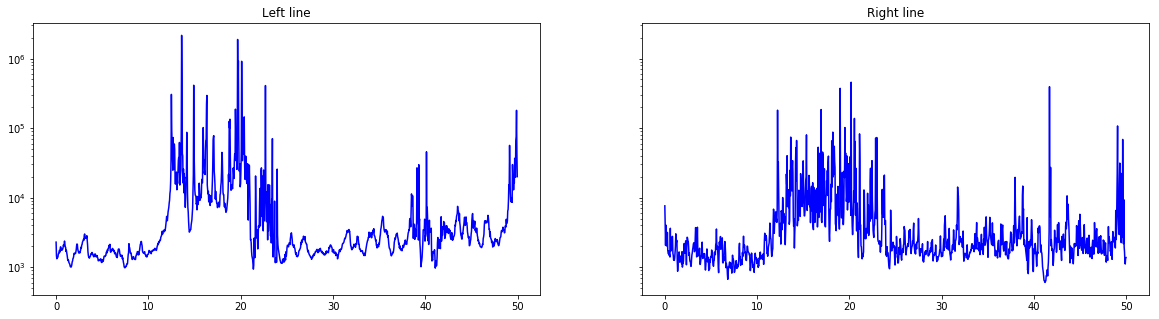

In [55]:
# Curvature plot
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=True)
ax[0].semilogy(x,proc.left_line.curvature,c='b')
ax[0].set_title("Left line")
ax[1].semilogy(x,proc.right_line.curvature,c='b')
ax[1].set_title("Right line")
plt.show()

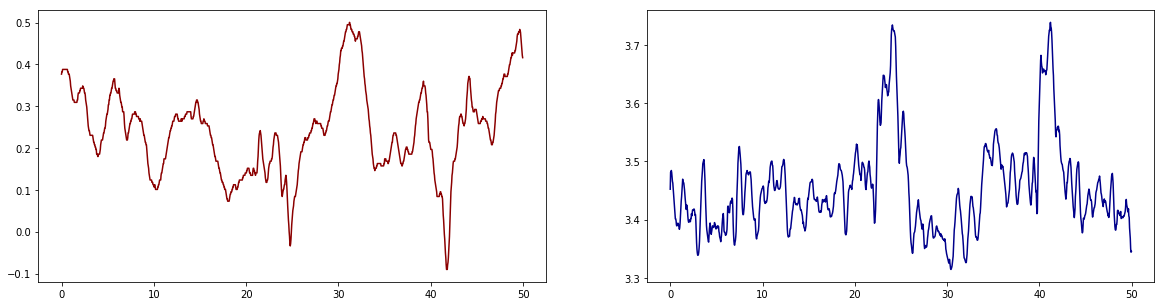

In [51]:
# Offset and lane width
f, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(x, proc.offset, c='darkred')
ax[1].plot(x, proc.lane_width, c='darkblue')
plt.show()

In [56]:
%%javascript
alert("done!")

<IPython.core.display.Javascript object>

In [36]:
proc.left_line.unfiltered_coeffs

array([[ -2.18121803e-04,   3.08772720e-01,   2.91505027e+02],
       [ -3.43055082e-04,   4.49275533e-01,   2.51373021e+02],
       [ -3.77465329e-04,   4.81164058e-01,   2.45517971e+02],
       ..., 
       [ -2.78153923e-06,  -1.94425883e-02,   4.27986233e+02],
       [ -1.12931195e-05,   2.84628353e-03,   4.14326752e+02],
       [ -2.49685363e-05,   2.19008267e-02,   4.05959400e+02]])

In [37]:
proc.left_line.curr_coeffs

array([  6.64928062e-06,  -3.48402304e-02,   4.36893931e+02])